# **Импорты библиотек**

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import ndcg_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# **Распаковка архивов**

In [3]:
!7z e "7z/members.csv.7z"
!7z e "7z/songs.csv.7z"
!7z e "7z/test.csv.7z"
!7z e "7z/train.csv.7z"
!7z e "7z/song_extra_info.csv.7z"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../input/kkbox-music-recommendation-challeng                                                      1 file, 1349856 bytes (1319 KiB)

Extracting archive: ../input/kkbox-music-recommendation-challenge/members.csv.7z
--
Path = ../input/kkbox-music-recommendation-challenge/members.csv.7z
Type = 7z
Physical Size = 1349856
Headers Size = 130
Method = LZMA2:3m
Solid = -
Blocks = 1

    Everything is Ok

Size:       2503827
Compressed: 1349856

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../input/kkbox-music-recommendation-challeng                                           

# **Сбор фреймов для обучения**

In [4]:
train = pd.read_csv('./train.csv')
train

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1
...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1


In [5]:
all_data = train.sample(frac=0.5)

Объединение данных о песнях и пользователях

In [6]:
songs = pd.read_csv('./songs.csv')
all_data = pd.merge(all_data, songs, on='song_id', how='left')
del songs

members = pd.read_csv('./members.csv')
all_data = pd.merge(all_data, members, on='msno', how='left')
del members

Результат

In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3688709 entries, 0 to 3688708
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   msno                    object 
 1   song_id                 object 
 2   source_system_tab       object 
 3   source_screen_name      object 
 4   source_type             object 
 5   target                  int64  
 6   song_length             float64
 7   genre_ids               object 
 8   artist_name             object 
 9   composer                object 
 10  lyricist                object 
 11  language                float64
 12  city                    int64  
 13  bd                      int64  
 14  gender                  object 
 15  registered_via          int64  
 16  registration_init_time  int64  
 17  expiration_date         int64  
dtypes: float64(2), int64(6), object(10)
memory usage: 534.7+ MB


In [6]:
all_data.describe()

,target,song_length,language,city,bd,registered_via,registration_init_time,expiration_date
count,3.688709e+06,3.688655e+06,3.688638e+06,3.688709e+06,3.688709e+06,3.688709e+06,3.688709e+06,3.688709e+06
mean,5.038096e-01,2.451343e+05,1.861946e+01,7.511602e+00,1.753461e+01,6.792854e+00,2.012811e+07,2.017157e+07
std,4.999856e-01,6.739833e+04,2.117949e+01,6.640936e+00,2.137652e+01,2.276392e+00,3.017480e+04,3.859891e+03
min,0.000000e+00,1.393000e+03,-1.000000e+00,1.000000e+00,-4.300000e+01,3.000000e+00,2.004033e+07,2.004102e+07
25%,0.000000e+00,2.147260e+05,3.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,2.011070e+07,2.017091e+07
50%,1.000000e+00,2.418240e+05,3.000000e+00,5.000000e+00,2.100000e+01,7.000000e+00,2.013102e+07,2.017093e+07
75%,1.000000e+00,2.721950e+05,5.200000e+01,1.300000e+01,2.900000e+01,9.000000e+00,2.015102e+07,2.017101e+07
max,1.000000e+00,1.080006e+07,5.900000e+01,2.200000e+01,1.051000e+03,1.300000e+01,2.017013e+07,2.020102e+07


# **Заполнение нулевых значений**

In [7]:
for col in all_data.select_dtypes(include=['object']).columns:
    all_data[col] = all_data[col].fillna(value = "unknown")
    
for col in all_data.select_dtypes(exclude=['object']).columns:
    all_data[col] = all_data[col].fillna(value = all_data[col].mean())

In [11]:
all_data.isna().sum()

msno                      0
song_id                   0
source_system_tab         0
source_screen_name        0
source_type               0
target                    0
song_length               0
genre_ids                 0
artist_name               0
composer                  0
lyricist                  0
language                  0
city                      0
bd                        0
gender                    0
registered_via            0
registration_init_time    0
expiration_date           0
dtype: int64

# **Извлечение данных о датах**

Извлечение и разбиение дат на столбцы

In [8]:
all_data['registration_init_time'] = pd.to_datetime(all_data['registration_init_time'], format='%Y%m%d', errors='ignore')
all_data['registration_init_time_year'] = all_data['registration_init_time'].dt.year
all_data['registration_init_time_month'] = all_data['registration_init_time'].dt.month
all_data['registration_init_time_day'] = all_data['registration_init_time'].dt.day


all_data['expiration_date'] = pd.to_datetime(all_data['expiration_date'],  format='%Y%m%d', errors='ignore')
all_data['expiration_date_year'] = all_data['expiration_date'].dt.year
all_data['expiration_date_month'] = all_data['expiration_date'].dt.month
all_data['expiration_date_day'] = all_data['expiration_date'].dt.day

Преобразование дат в категории

In [9]:
all_data['registration_init_time'] = all_data['registration_init_time'].astype('category')
all_data['expiration_date'] = all_data['expiration_date'].astype('category') 

In [21]:
all_data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,RoD5gyOLtPc5/3JkXTP58/oc7oo6IUPFbGkjJdd5J+0=,laTO6P3BEwoQfuvXmSiGnHiYJhgr5Pv9FtJk7U4VkoU=,discover,unknown,song,0,124458.0,545,思嘉姐姐,思嘉姐姐,...,unknown,4,2016-12-22,2017-01-18,2016,12,22,2017,1,18
1,93fFAKMNUoj3G9d6eGldoKl/+qYOi6VWb8+aqfejE7w=,1i204ksC2VGIc3K7kPB/30CPanJAF4N1dOh8Zgbbju4=,my library,Local playlist more,local-library,1,233430.0,458,16個夏天 電視原聲帶,Lin Jix| James Gicho| Pontus Sodergvist,...,male,9,2007-07-14,2017-08-08,2007,7,14,2017,8,8
2,o83Eezz/BHCJimugx6jC4MS2WKirFql2hC3gBovAk/0=,w3wy8QbC9QcksSpToIRFnnobkOq1nK5zRA/h8rtFNRg=,discover,Online playlist more,online-playlist,1,172571.0,726,Brian Crain,unknown,...,unknown,7,2014-12-17,2017-01-20,2014,12,17,2017,1,20
3,2NHy2X3I6unr3kXaliBWkT1ykRwrj9P2B/Jhy7zLrVg=,KWMaHRIODtFWghvr8etVHASdRhv8NfG/lgT6f/39cNY=,my library,Local playlist more,local-library,1,244128.0,458,王詩安 (Diana Wang),Skot Suyama 陶山,...,female,9,2016-09-03,2017-09-08,2016,9,3,2017,9,8
4,iOayfrJuEaVtgNGUmmjY1JeEhzqyTv8RMPVAI5Nokj8=,kVtk5At17zUXW2nlGMaiV1zqNH1eUhbft0/nM0iXNwI=,my library,Local playlist more,local-library,1,221982.0,465,Kelly Clarkson,Jörgen Elofsson| Ali Tamposi| Greg Kurstin| Da...,...,female,9,2015-04-28,2017-09-29,2015,4,28,2017,9,29


# **Кодирование столбцов**

Преобразование объектов в категории

In [10]:
for col in all_data.select_dtypes(include=['object']).columns:
    all_data[col] = all_data[col].astype('category')

for col in all_data.select_dtypes(include=['category']).columns:
    all_data[col] = all_data[col].cat.codes

Результат

In [18]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3688709 entries, 0 to 3688708
Data columns (total 24 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   msno                          int16  
 1   song_id                       int32  
 2   source_system_tab             int8   
 3   source_screen_name            int8   
 4   source_type                   int8   
 5   target                        int64  
 6   song_length                   float64
 7   genre_ids                     int16  
 8   artist_name                   int16  
 9   composer                      int32  
 10  lyricist                      int16  
 11  language                      float64
 12  city                          int64  
 13  bd                            int64  
 14  gender                        int8   
 15  registered_via                int64  
 16  registration_init_time        int16  
 17  expiration_date               int16  
 18  registration_init_time

In [19]:
all_data.describe()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
count,3.688709e+06,3.688709e+06,3.688709e+06,3.688709e+06,3.688709e+06,3.688709e+06,3.688709e+06,3.688709e+06,3.688709e+06,3.688709e+06,...,3.688709e+06,3.688709e+06,3.688709e+06,3.688709e+06,3.688709e+06,3.688709e+06,3.688709e+06,3.688709e+06,3.688709e+06,3.688709e+06
mean,1.505687e+04,1.294758e+05,2.441461e+00,9.082809e+00,4.764316e+00,5.038096e-01,2.451343e+05,3.067762e+02,2.178998e+04,4.182642e+04,...,1.113957e+00,6.792854e+00,2.543851e+03,9.441970e+02,2.012741e+03,6.832488e+00,1.581443e+01,2.017072e+03,8.341561e+00,1.562369e+01
std,8.683695e+03,7.495616e+04,1.889233e+00,4.590325e+00,2.468010e+00,4.999856e-01,6.739784e+04,9.037434e+01,1.000271e+04,1.646891e+04,...,8.219667e-01,2.276392e+00,9.642739e+02,1.118858e+02,3.019064e+00,3.699982e+00,8.769782e+00,3.972865e-01,2.511898e+00,9.106021e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.393000e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,2.004000e+03,1.000000e+00,1.000000e+00,2.004000e+03,1.000000e+00,1.000000e+00
25%,7.531000e+03,6.440300e+04,0.000000e+00,8.000000e+00,3.000000e+00,0.000000e+00,2.147260e+05,3.140000e+02,1.396100e+04,2.999400e+04,...,0.000000e+00,4.000000e+00,1.945000e+03,9.330000e+02,2.011000e+03,3.000000e+00,8.000000e+00,2.017000e+03,9.000000e+00,8.000000e+00
50%,1.514200e+04,1.289770e+05,3.000000e+00,8.000000e+00,4.000000e+00,1.000000e+00,2.418240e+05,3.200000e+02,2.711600e+04,5.023700e+04,...,1.000000e+00,7.000000e+00,2.674000e+03,9.480000e+02,2.013000e+03,7.000000e+00,1.600000e+01,2.017000e+03,9.000000e+00,1.500000e+01
75%,2.262600e+04,1.932990e+05,3.000000e+00,1.100000e+01,6.000000e+00,1.000000e+00,2.721950e+05,3.200000e+02,2.947600e+04,5.310000e+04,...,2.000000e+00,9.000000e+00,3.403000e+03,9.580000e+02,2.015000e+03,1.000000e+01,2.300000e+01,2.017000e+03,1.000000e+01,2.300000e+01
max,3.003100e+04,2.597560e+05,8.000000e+00,2.000000e+01,1.200000e+01,1.000000e+00,1.080006e+07,5.290000e+02,3.229300e+04,5.953200e+04,...,2.000000e+00,1.300000e+01,3.805000e+03,1.362000e+03,2.017000e+03,1.200000e+01,3.100000e+01,2.020000e+03,1.200000e+01,3.100000e+01


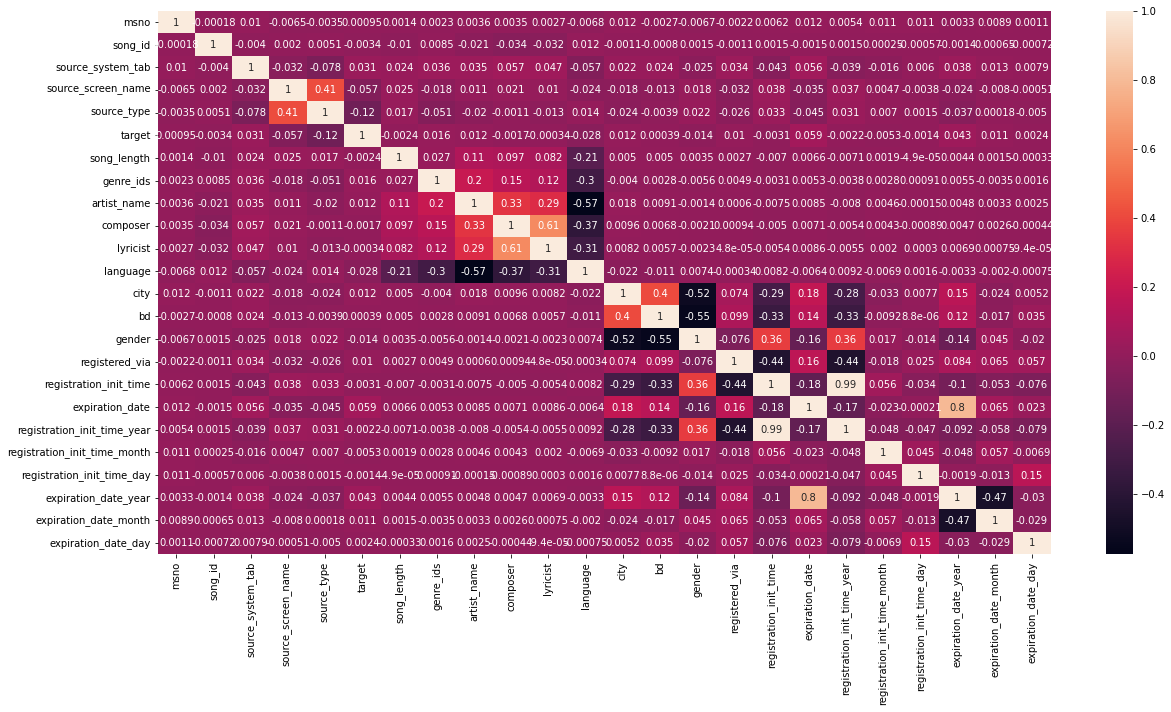

In [20]:
plt.figure(figsize=[20,10])
sns.heatmap(all_data.corr(), annot=True)
plt.show()

# **Разбиение данных для обучения**

In [11]:
target = all_data.pop('target')
train_data, test_data, train_labels, test_labels = train_test_split( all_data , target, test_size = 0.2)

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(2950967, 23)
(2950967,)
(737742, 23)
(737742,)


# **Random Forest**

Объявляем и тренируем RandomForestClassifier для решения проблемы классификации

In [21]:

RF = RandomForestClassifier()
RF.fit(train_data, train_labels)

RF_TrainScore = RF.score(train_data, train_labels)
RF_TrainScore

0.999994239176514

In [22]:
RF_TestScore = RF.score(test_data, test_labels)
RF_TestScore

0.7164374537439918

Проверка обученной модели

In [23]:
y_pred_rf = RF.predict(test_data)

<AxesSubplot:>

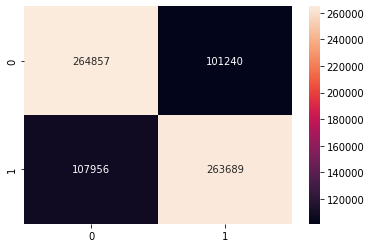

In [25]:
cm_rf = confusion_matrix(test_labels, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='g')

Результат

In [26]:
ndcg_score([test_labels.to_numpy()], [y_pred_rf])

0.9685407383193338

In [30]:
print(classification_report(test_labels, y_pred_rf))

              precision    recall  f1-score   support

           0       0.71      0.72      0.72    366099
           1       0.72      0.71      0.72    371643

    accuracy                           0.72    737742
   macro avg       0.72      0.72      0.72    737742
weighted avg       0.72      0.72      0.72    737742



**Ранжирование по важности атрибутов классификации**

In [31]:
df_plot = pd.DataFrame({'features': all_data.columns,
                        'importances': RF.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

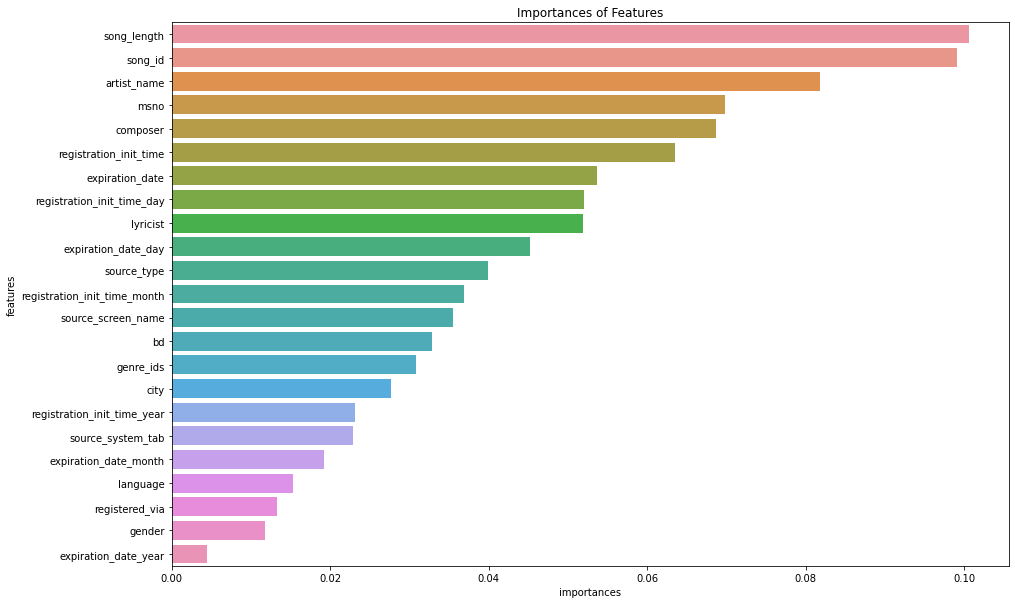

In [32]:
plt.figure(figsize=[15,10])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features')
plt.show()

# **XGBoost**

Инициализация и обучение модели классификации

In [30]:
XGB = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5)
XGB.fit(train_data, train_labels)

XGB_TrainScore = XGB.score(train_data, train_labels)
XGB_TrainScore

0.7607916320311274

In [31]:
XGB_TestScore = XGB.score(test_data, test_labels)
XGB_TestScore

0.7103594481539617

Проверка результатов обучения

In [32]:
y_pred_xgb = XGB.predict(test_data)

<AxesSubplot:>

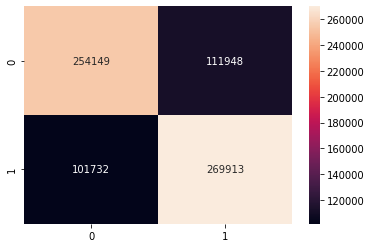

In [33]:
cm_lgbm = confusion_matrix(test_labels, y_pred_xgb)
sns.heatmap(cm_lgbm, annot=True, fmt='g')

Результат

In [34]:
ndcg_score([test_labels.to_numpy()], [y_pred_xgb])

0.9672699252206517

In [35]:
print(classification_report(test_labels, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70    366097
           1       0.71      0.73      0.72    371645

    accuracy                           0.71    737742
   macro avg       0.71      0.71      0.71    737742
weighted avg       0.71      0.71      0.71    737742



# **Сравнение обученных моделей**

In [39]:
results = pd.DataFrame( [["Random Forest", RF_TrainScore, RF_TestScore ],
                       ["XGBoost", XGB_TrainScore ,XGB_TestScore ]],
                       columns = ["Model","Training Accuracy %","Test Evaluation %"]).sort_values(by="Test Evaluation %",ascending=False)
results

,Model,Training Accuracy %,Test Evaluation %
0,Random Forest,0.999994,0.716437
1,XGBoost,0.760792,0.710359
